# Creating an interannual monthly photoC that I can save and be able to more easily use in my other figures

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

%matplotlib inline
from glob import glob
import dask
import esmlab
import pop_tools 
from statistics import mean

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality and interannual variability in SPECTRA

In [32]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [8]:
variables = [f'{var}' for var in ['photoC_TOT']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [7]:
%%time

ds_01_avg = xr.Dataset()
ds_02_avg = xr.Dataset()
ds_03_avg = xr.Dataset()
ds_04_avg = xr.Dataset()
ds_05_avg = xr.Dataset()
ds_06_avg = xr.Dataset()
ds_07_avg = xr.Dataset()
ds_08_avg = xr.Dataset()
ds_09_avg = xr.Dataset()
ds_10_avg = xr.Dataset()
ds_11_avg = xr.Dataset()
ds_12_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_01 = xr.Dataset()
    ds_02 = xr.Dataset()
    ds_03 = xr.Dataset()
    ds_04 = xr.Dataset()
    ds_05 = xr.Dataset()
    ds_06 = xr.Dataset()
    ds_07 = xr.Dataset()
    ds_08 = xr.Dataset()
    ds_09 = xr.Dataset()
    ds_10 = xr.Dataset()
    ds_11 = xr.Dataset()
    ds_12 = xr.Dataset()

    file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
        
    dsv_01=xr.open_mfdataset(file[0], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_02=xr.open_mfdataset(file[1], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_03=xr.open_mfdataset(file[2], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_04=xr.open_mfdataset(file[3], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_05=xr.open_mfdataset(file[4], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_06=xr.open_mfdataset(file[5], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_07=xr.open_mfdataset(file[6], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_08=xr.open_mfdataset(file[7], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_09=xr.open_mfdataset(file[8], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_10=xr.open_mfdataset(file[9], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_11=xr.open_mfdataset(file[10], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_12=xr.open_mfdataset(file[11], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_01 = xr.merge((ds_01, dsv_01[vv]))
        ds_02 = xr.merge((ds_02, dsv_02[vv]))
        ds_03 = xr.merge((ds_03, dsv_03[vv]))
        ds_04 = xr.merge((ds_04, dsv_04[vv]))
        ds_05 = xr.merge((ds_05, dsv_05[vv]))
        ds_06 = xr.merge((ds_06, dsv_06[vv]))
        ds_07 = xr.merge((ds_07, dsv_07[vv]))
        ds_08 = xr.merge((ds_08, dsv_08[vv]))
        ds_09 = xr.merge((ds_09, dsv_09[vv]))
        ds_10 = xr.merge((ds_10, dsv_10[vv]))
        ds_11 = xr.merge((ds_11, dsv_11[vv]))
        ds_12 = xr.merge((ds_12, dsv_12[vv]))
        

    ds_01 = ds_01.drop([v for v in ds_01.variables if v not in keep_vars]).squeeze()
    ds_01 = ds_01.mean(dim='time')
    ds_01_avg = xr.concat([ds_01_avg, ds_01],dim='year')
    
    ds_02 = ds_02.drop([v for v in ds_02.variables if v not in keep_vars]).squeeze()
    ds_02 = ds_02.mean(dim='time')
    ds_02_avg = xr.concat([ds_02_avg, ds_02],dim='year')
    
    ds_03 = ds_03.drop([v for v in ds_03.variables if v not in keep_vars]).squeeze()
    ds_03 = ds_03.mean(dim='time')
    ds_03_avg = xr.concat([ds_03_avg, ds_03],dim='year')
    
    ds_04 = ds_04.drop([v for v in ds_04.variables if v not in keep_vars]).squeeze()
    ds_04 = ds_04.mean(dim='time')
    ds_04_avg = xr.concat([ds_04_avg, ds_04],dim='year')
    
    ds_05 = ds_05.drop([v for v in ds_05.variables if v not in keep_vars]).squeeze()
    ds_05 = ds_05.mean(dim='time')
    ds_05_avg = xr.concat([ds_05_avg, ds_05],dim='year')
    
    ds_06 = ds_06.drop([v for v in ds_06.variables if v not in keep_vars]).squeeze()
    ds_06 = ds_06.mean(dim='time')
    ds_06_avg = xr.concat([ds_06_avg, ds_06],dim='year')
    
    ds_07 = ds_07.drop([v for v in ds_07.variables if v not in keep_vars]).squeeze()
    ds_07 = ds_07.mean(dim='time')
    ds_07_avg = xr.concat([ds_07_avg, ds_07],dim='year')
    
    ds_08 = ds_08.drop([v for v in ds_08.variables if v not in keep_vars]).squeeze()
    ds_08 = ds_08.mean(dim='time')
    ds_08_avg = xr.concat([ds_08_avg, ds_08],dim='year')
    
    ds_09 = ds_09.drop([v for v in ds_09.variables if v not in keep_vars]).squeeze()
    ds_09 = ds_09.mean(dim='time')
    ds_09_avg = xr.concat([ds_09_avg, ds_09],dim='year')
    
    ds_10 = ds_10.drop([v for v in ds_10.variables if v not in keep_vars]).squeeze()
    ds_10 = ds_10.mean(dim='time')
    ds_10_avg = xr.concat([ds_10_avg, ds_10],dim='year')
    
    ds_11 = ds_11.drop([v for v in ds_11.variables if v not in keep_vars]).squeeze()
    ds_11 = ds_11.mean(dim='time')
    ds_11_avg = xr.concat([ds_11_avg, ds_11],dim='year')
    
    ds_12 = ds_12.drop([v for v in ds_12.variables if v not in keep_vars]).squeeze()
    ds_12 = ds_12.mean(dim='time')
    ds_12_avg = xr.concat([ds_12_avg, ds_12],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 9min 22s, sys: 30.6 s, total: 9min 53s
Wall time: 11min 22s


In [38]:
%%time
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_01_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    for month in months:
    
        ds_01 = xr.Dataset()

        file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-{month}.nc'))
        
        dsv_01=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
        for vv in variables: 
            ds_01 = xr.merge((ds_01, dsv_01[vv]))

            ds_01 = ds_01.drop([v for v in ds_01.variables if v not in keep_vars]).squeeze()
            ds_01_avg = xr.concat([ds_01_avg, ds_01],dim='year')
    

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 10min 13s, sys: 52.6 s, total: 11min 6s
Wall time: 12min 27s


## Plot this to make sure this is correct.. 

Text(0.5, 1.0, 'Annual surface photoC_TOT (mmol m-3)')

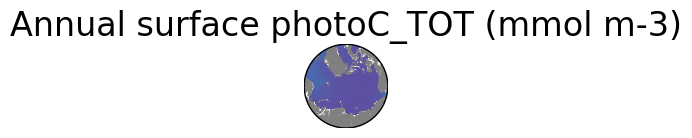

In [41]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
lon, lat, winter = adjust_pop_grid(ds_01_avg.TLONG, ds_01_avg.TLAT, np.nanmean(ds_01_avg.photoC_TOT[:,0,:,:],axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Annual surface photoC_TOT (mmol m-3)', fontsize =24)

In [42]:
%%time
photoC_ds_inter = np.empty([62,12,15,384,320])
photoC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    photoC_ds_inter[i,:,:,:,:] = ds_01_avg.photoC_TOT[x[i]:x[i]+12,:,:,:]

CPU times: user 33.9 s, sys: 1min 13s, total: 1min 47s
Wall time: 4min 41s


In [43]:
photoC_ds_inter.shape

(62, 12, 15, 384, 320)

In [18]:
month = np.arange(0,12,1)
time = np.arange(0,62,1)
phyto_bmss = xr.DataArray(photoC_ds_inter, coords={'time':time,'month':month, 'z_t_150m':dsv_01.z_t_150m, 'TLAT':ds_01_avg.TLAT, 'TLONG':ds_01_avg.TLONG},
                      dims=['time','month','z_t_150m', 'nlat', 'nlon'])
phyto_bmss = phyto_bmss.to_dataset(name='photoC_TOT')

In [19]:
phyto_bmss

<xarray.Dataset>
Dimensions:     (time: 62, month: 12, z_t_150m: 15, nlat: 384, nlon: 320)
Coordinates:
  * time        (time) int64 0 1 2 3 4 5 6 7 8 9 ... 53 54 55 56 57 58 59 60 61
  * month       (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
Dimensions without coordinates: nlat, nlon
Data variables:
    photoC_TOT  (time, month, z_t_150m, nlat, nlon) float64 nan nan ... nan nan

In [20]:
phyto_bmss.to_netcdf('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/photoC_TOT_62yr_monthly.nc');

	NC4_create: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/photoC_TOT_62yr_monthly.nc cmode 0x1000 parameters (nil)
	HDF5 error messages turned on.
			nc4_create_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/photoC_TOT_62yr_monthly.nc mode 0x1000
			nc4_grp_list_add: name / 
		nc_inq_format: ncid 0x3f0000
		NC4_inq_format_extended: ncid 0x3f0000
		nc_inq_typeids: ncid 0x3f0000
		NC4_inq: ncid 0x3f0000
		NC4_inq: ncid 0x3f0000
		nc_inq_grps: ncid 0x3f0000
		NC4_def_dim: ncid 0x3f0000 name time len 62
		NC4_def_dim: ncid 0x3f0000 name month len 12
		NC4_def_dim: ncid 0x3f0000 name z_t_150m len 15
		NC4_def_dim: ncid 0x3f0000 name nlat len 384
		NC4_def_dim: ncid 0x3f0000 name nlon len 320
		NC4_def_var: name time type 10 ndims 1
		NC4_inq_unlimdims: ncid 0x3f0000
		NC4_inq_var_all: ncid 0x3f0000 varid 0
		NC4_inq_var_all: ncid 0x3f0000 varid 0
		NC4_inq_var_all: ncid 0x3f0000 varid 0
		NC4_inq_var_all: ncid 0x3f0000 varid 0
		NC4_inq_dim: ncid 0x3f0000 dimid 0
		NC4_inq_dim

In [44]:
phytoC_bm_150m = np.nansum(photoC_ds_inter, axis=2) * 10/150 #integrate over depth #mmol m-3
phytoC_bm_150m = phytoC_bm_150m * 12.011 *1000 # ug C m-3 --> ugC m^{-3}

In [46]:
phytoC_bm_150m.shape

(62, 12, 384, 320)

Text(0.5, 1.0, 'Annual top 150m photoC_TOT (ugC m^{-3})')

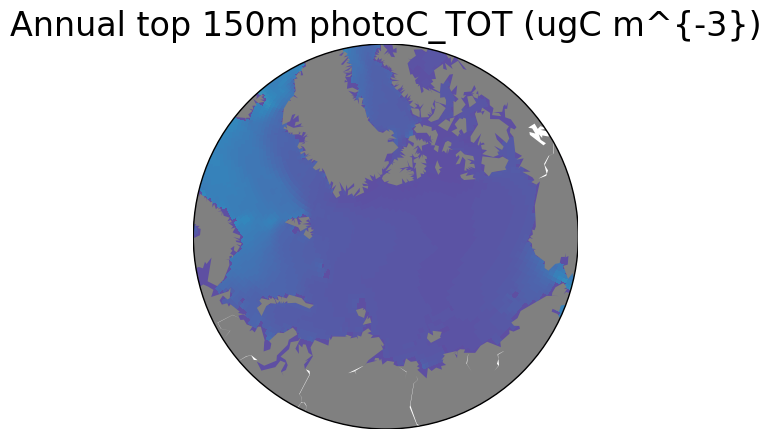

In [48]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
lon, lat, winter = adjust_pop_grid(ds_01_avg.TLONG, ds_01_avg.TLAT, np.nanmean(phytoC_bm_150m,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Annual top 150m photoC_TOT (ugC m^{-3})', fontsize =24)

In [49]:
month = np.arange(0,12,1)
time = np.arange(0,62,1)
phyto_bmss_150m = xr.DataArray(phytoC_bm_150m, coords={'time':time,'month':month, 'TLAT':ds_01_avg.TLAT, 'TLONG':ds_01_avg.TLONG},
                                    dims=['time','month', 'nlat', 'nlon'],
                                    attrs=dict(description="photoC_TOT integrated over depth (150m)",units="ugC m^{-3}"))
phyto_bmss_150m = phyto_bmss_150m.to_dataset(name='photoC_TOT')

In [50]:
phyto_bmss_150m

<xarray.Dataset>
Dimensions:     (time: 62, month: 12, nlat: 384, nlon: 320)
Coordinates:
  * time        (time) int64 0 1 2 3 4 5 6 7 8 9 ... 53 54 55 56 57 58 59 60 61
  * month       (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
Dimensions without coordinates: nlat, nlon
Data variables:
    photoC_TOT  (time, month, nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [51]:
phyto_bmss_150m.to_netcdf('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/photoC_TOT_62yr_monthly_150m.nc');

	NC4_create: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/photoC_TOT_62yr_monthly_150m.nc cmode 0x1000 parameters (nil)
	HDF5 error messages turned on.
			nc4_create_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/photoC_TOT_62yr_monthly_150m.nc mode 0x1000
			nc4_grp_list_add: name / 
		nc_inq_format: ncid 0x10000
		NC4_inq_format_extended: ncid 0x10000
		nc_inq_typeids: ncid 0x10000
		NC4_inq: ncid 0x10000
		NC4_inq: ncid 0x10000
		nc_inq_grps: ncid 0x10000
		NC4_def_dim: ncid 0x10000 name time len 62
		NC4_def_dim: ncid 0x10000 name month len 12
		NC4_def_dim: ncid 0x10000 name nlat len 384
		NC4_def_dim: ncid 0x10000 name nlon len 320
		NC4_def_var: name time type 10 ndims 1
		NC4_inq_unlimdims: ncid 0x10000
		NC4_inq_var_all: ncid 0x10000 varid 0
		NC4_inq_var_all: ncid 0x10000 varid 0
		NC4_inq_var_all: ncid 0x10000 varid 0
		NC4_inq_var_all: ncid 0x10000 varid 0
		NC4_inq_dim: ncid 0x10000 dimid 0
		NC4_inq_dim: ncid 0x10000 dimid 0
		NC4_inq_var_all: ncid 0x10000 v

## Now that they are saved, convert to 180 by 360 grid

In [ ]:
## 3. Regrid from that nc file (you can do this in bash)
Biomass  

    * cd /glade/u/home/gabyn/scratch/SPECTRA/nc_files'
    * ncatted -a coordinates,photoC_TOT,c,c,"TLONG TLAT" photoC_TOT_62yr_monthly.nc
    * cdo remapbil,r360x180 -selname,photoC_TOT photoC_TOT_62yr_monthly.nc photoC_TOT_62yr_monthly_regrid.nc
    * cdo sellonlatbox,-180,180,-89.5,89.5 photoC_TOT_62yr_monthly_regrid.nc regrid_photoC_TOT_62yr_monthly.nc

Biomass integrated over the top 150m.  

    * ncatted -a coordinates,photoC_TOT,c,c,"TLONG TLAT" photoC_TOT_62yr_monthly_150m.nc
    * cdo remapbil,r360x180 -selname,photoC_TOT photoC_TOT_62yr_monthly_150m.nc photoC_TOT_62yr_monthly_150m_regrid.nc
    * cdo sellonlatbox,-180,180,-89.5,89.5 photoC_TOT_62yr_monthly_150m_regrid.nc regrid_photoC_TOT_62yr_monthly_150m.nc